In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from matplotlib.mlab import PCA as mlabPCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.stats as stats

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [3]:
from sklearn import neighbors

# Melbourne Housing Market EDA
https://www.kaggle.com/anthonypino/melbourne-housing-market

Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from Melbourne Central Business District in Kilometres

Regionname: General Region (West, North West, North, North east ...etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Latitude

Longitude



## Selected variables:

Outcome variable: Price

Categorical variables:
* Type
* Rooms
* Car

Continuous variables (or discrete that can work as continuous):
* Distance
* Landsize
* BuildingArea
* YearBuilt


In [4]:
df_raw = pd.read_csv('melbourne-housing-market/Melbourne_housing_FULL.csv')

# Too many Ts.

df_raw.rename(columns = {'Lattitude': 'Latitude', 'Longtitude': 'Longitude'}, inplace=True)

In [5]:
df_raw.Date = pd.to_datetime(df_raw.Date)
df_raw.Date.head()

0   2016-03-09
1   2016-03-12
2   2016-04-02
3   2016-04-02
4   2017-04-03
Name: Date, dtype: datetime64[ns]

In [6]:
#Substitute "YearBuilt: 1196" outlier with mean for neighborhood:
df_raw[df_raw['Suburb'] == 'Mount Waverley']['YearBuilt'].mean()

1965.107142857143

In [7]:
df_raw.loc[lambda df: df_raw['YearBuilt'] == 1196, 'YearBuilt'] = 1965
df_raw.loc[lambda df: df_raw['YearBuilt'] == 2019, 'YearBuilt'] = 2018

In [8]:
df = df_raw.dropna()

features = df.drop(['Suburb','Address','SellerG','Method','Postcode','CouncilArea','Regionname'], axis=1)

features.head()

,Rooms,Type,Price,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount
2,2,h,1035000.0,2016-04-02,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
4,3,h,1465000.0,2017-04-03,2.5,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0
6,4,h,1600000.0,2016-04-06,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0
11,3,h,1876000.0,2016-07-05,2.5,4.0,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,4019.0
14,2,h,1636000.0,2016-08-10,2.5,2.0,1.0,2.0,256.0,107.0,1890.0,-37.8060,144.9954,4019.0


In [9]:
df[df['BuildingArea'] > 0]['BuildingArea'].describe()

count    8842.000000
mean      150.069365
std        87.499764
min         1.000000
25%       100.000000
50%       132.000000
75%       180.000000
max      3112.000000
Name: BuildingArea, dtype: float64

In [10]:
df['Rooms'].describe()

count    8887.000000
mean        3.098909
std         0.963786
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        12.000000
Name: Rooms, dtype: float64

In [11]:
df['Bathroom'].describe()

count    8887.000000
mean        1.646450
std         0.721611
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         9.000000
Name: Bathroom, dtype: float64

(array([  8.52400000e+03,   3.39000000e+02,   1.90000000e+01,
          3.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    0. ,   311.2,   622.4,   933.6,  1244.8,  1556. ,  1867.2,
         2178.4,  2489.6,  2800.8,  3112. ]),
 <a list of 10 Patch objects>)

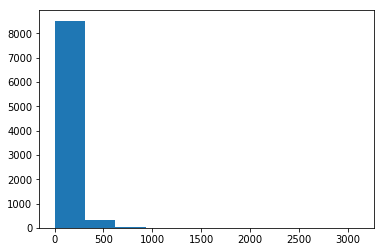

In [12]:
plt.hist(df['BuildingArea'])

## Correlation Matrix for Original Features

In [13]:
corrmat = features.corr()

corrmat

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount
Rooms,1.000000,0.475074,0.276585,0.964465,0.624070,0.401423,0.101158,0.606738,0.006864,0.018758,0.083016,-0.082797
Price,0.475074,1.000000,-0.231212,0.460880,0.463501,0.209464,0.058375,0.507284,-0.321200,-0.224255,0.212174,-0.059720
Distance,0.276585,-0.231212,1.000000,0.283460,0.122132,0.259374,0.138559,0.135509,0.322344,-0.055317,0.163941,-0.003247
Bedroom2,0.964465,0.460880,0.283460,1.000000,0.626493,0.405570,0.101035,0.595299,0.016528,0.022745,0.082671,-0.081392
Bathroom,0.624070,0.463501,0.122132,0.626493,1.000000,0.310962,0.075939,0.553855,0.195639,-0.041859,0.109268,-0.058324
Car,0.401423,0.209464,0.259374,0.405570,0.310962,1.000000,0.123498,0.317593,0.148428,0.015139,0.035589,-0.031285
Landsize,0.101158,0.058375,0.138559,0.101035,0.075939,0.123498,1.000000,0.083229,0.039345,0.042484,-0.008196,-0.032548
BuildingArea,0.606738,0.507284,0.135509,0.595299,0.553855,0.317593,0.083229,1.000000,0.060565,-0.034626,0.097635,-0.059024
YearBuilt,0.006864,-0.321200,0.322344,0.016528,0.195639,0.148428,0.039345,0.060565,1.000000,0.100882,-0.024951,0.020884
Latitude,0.018758,-0.224255,-0.055317,0.022745,-0.041859,0.015139,0.042484,-0.034626,0.100882,1.000000,-0.345797,0.029793


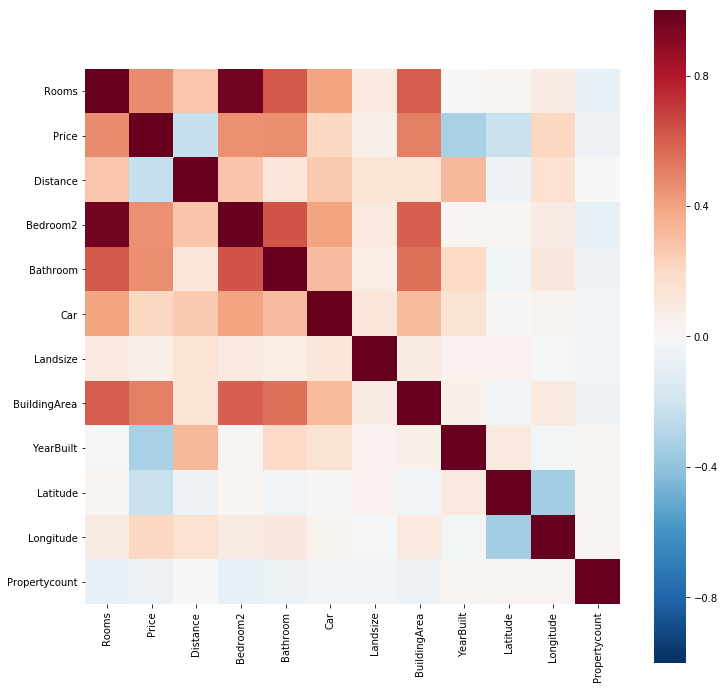

In [14]:
plt.rcParams['figure.figsize'] = 12, 12

f = sns.heatmap(corrmat, vmin= -1, vmax=1, square=True, cmap="RdBu_r")

plt.show()

In [15]:
corrmagnitude = pd.DataFrame(corrmat['Price']).reset_index().rename(columns={'index': 'Column',
                                                                'Price': 'PriceCorrMagnitude'})
corrmagnitude['PriceCorrMagnitude'] = corrmagnitude['PriceCorrMagnitude'].apply(lambda x: abs(x))

corrmagnitude.sort_values(by='PriceCorrMagnitude', ascending=False)

,Column,PriceCorrMagnitude
1,Price,1.000000
7,BuildingArea,0.507284
0,Rooms,0.475074
4,Bathroom,0.463501
3,Bedroom2,0.460880
8,YearBuilt,0.321200
2,Distance,0.231212
9,Latitude,0.224255
10,Longitude,0.212174
5,Car,0.209464


### Regression plots of Distance, Price, and Year Built

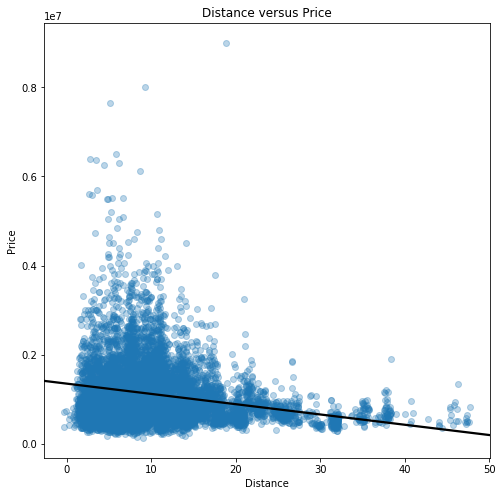

In [16]:
plt.rcParams['figure.figsize'] = 8, 8

sns.regplot(features['Distance'], features['Price'],
            x_jitter=0.49, y_jitter=0.49, scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.title('Distance versus Price')

plt.show()

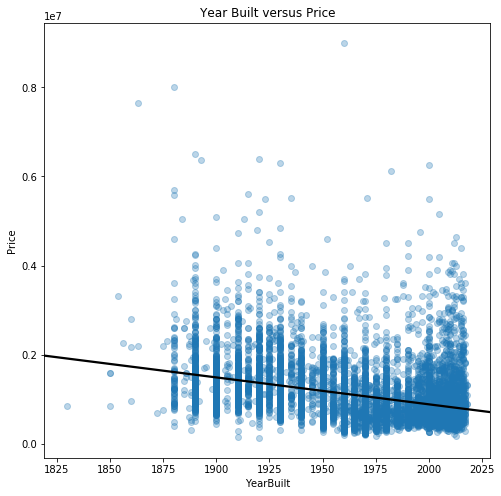

In [17]:
sns.regplot(features['YearBuilt'], features['Price'],
    x_jitter=0.0, y_jitter=0.0, scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.title('Year Built versus Price')

plt.show()

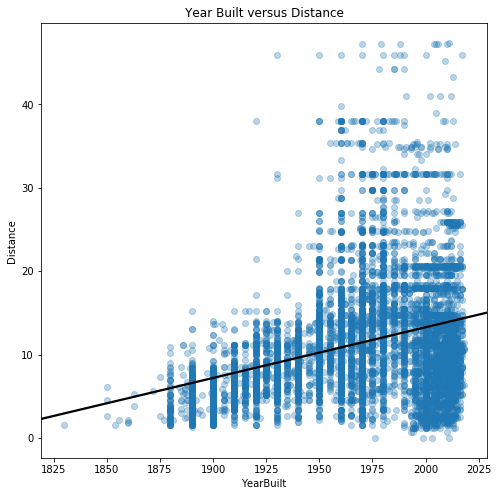

In [18]:
#YearBuilt v Distance shows city's expansion over time

sns.regplot(features['YearBuilt'], features['Distance'],
            x_jitter=0.0, y_jitter=0.0, scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.title('Year Built versus Distance')

plt.show()

In [19]:
stats.pearsonr(features['YearBuilt'], features['Price'])[0]

-0.3212002464199526

## Longitude/Lattitude Heatmap of Houses in Survey

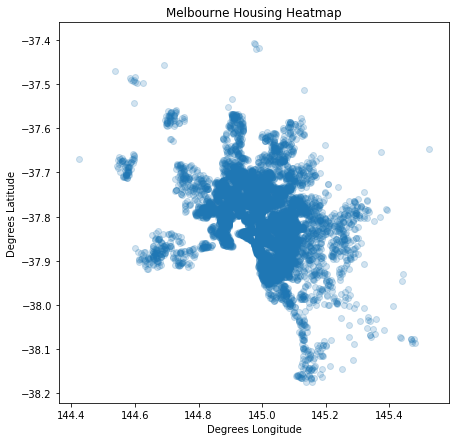

In [20]:
plt.rcParams['figure.figsize'] = 7, 7

plt.scatter(df['Longitude'], df['Latitude'], alpha=.2)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Melbourne Housing Heatmap')
plt.show()

### Boxplots of Price by Rooms, Type, Car Spots

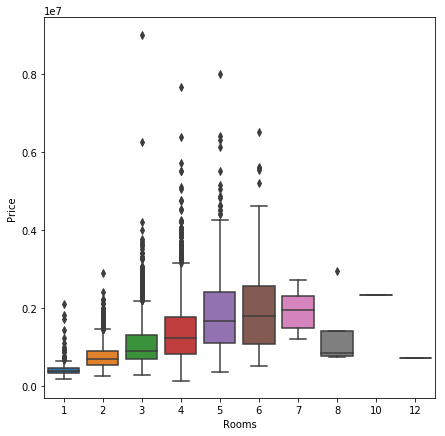

In [21]:
plt.rcParams['figure.figsize'] = 7, 7
sns.boxplot(df['Rooms'], df['Price'])
plt.show()

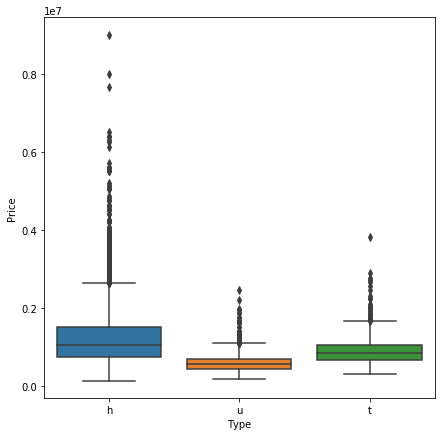

In [22]:
plt.rcParams['figure.figsize'] = 7, 7
sns.boxplot(df['Type'], df['Price'])
plt.show()

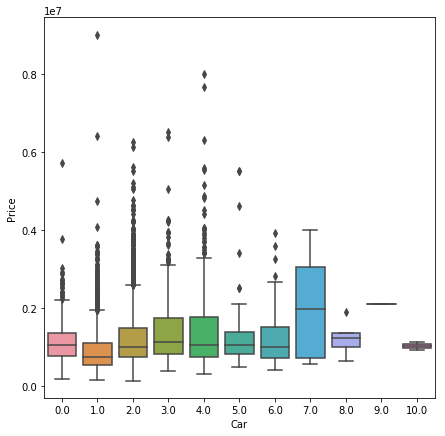

In [23]:
plt.rcParams['figure.figsize'] = 7, 7
sns.boxplot(df['Car'], df['Price'])
plt.show()

### Pairs Plot of Features

In [24]:
"""sns.pairplot(features)

plt.show()"""

'sns.pairplot(features)\n\nplt.show()'

# Histograms of Continuous Variables with Transformations

In [25]:
def plotcolumn(plotterm, features=features):
    plt.rcParams['figure.figsize'] = 12, 8
    fig = plt.figure()

    fig.add_subplot(231)
    plt.hist(features[plotterm])
    plt.title('{} Raw'.format(plotterm))

    fig.add_subplot(232)
    plt.hist(np.log(features[plotterm]+1))
    plt.title('{} Log'.format(plotterm))

    fig.add_subplot(233)
    plt.hist((features[plotterm])**2)
    plt.title('{} Square'.format(plotterm))
    
    fig.add_subplot(235)
    plt.hist(np.sqrt(features[plotterm]+1))
    plt.title('{} Square Root'.format(plotterm))
    
    ax3=fig.add_subplot(236)
    plt.hist(1/(features[plotterm]+1))
    plt.title('{} Inverse'.format(plotterm))
    plt.xticks(rotation=90)
    plt.show()

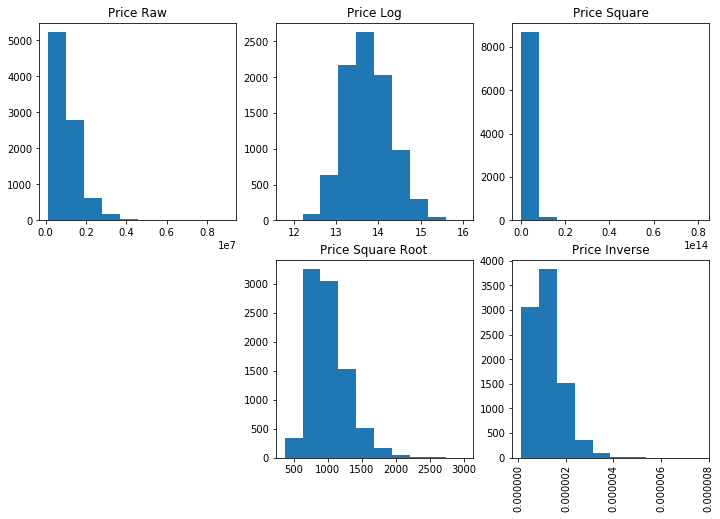

In [26]:
plotcolumn('Price')

The log transform of Price looks the most normally-distributed.

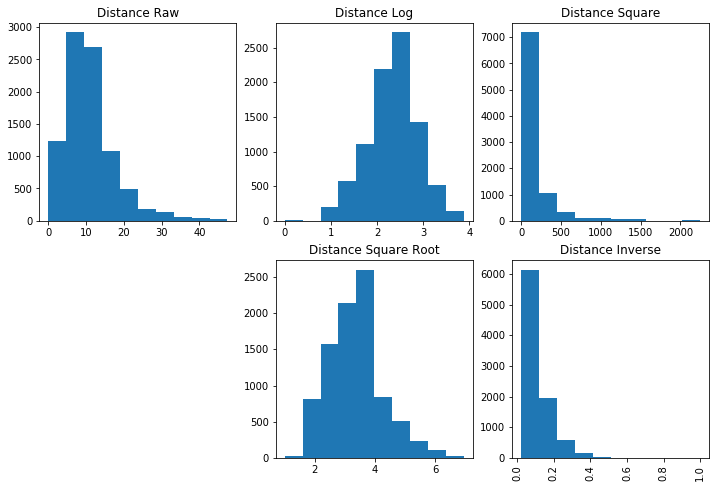

In [27]:
plotcolumn('Distance')

The log transform of Distance looks the most normally-distributed, but we could also try making it into a "Proximity" feature instead.

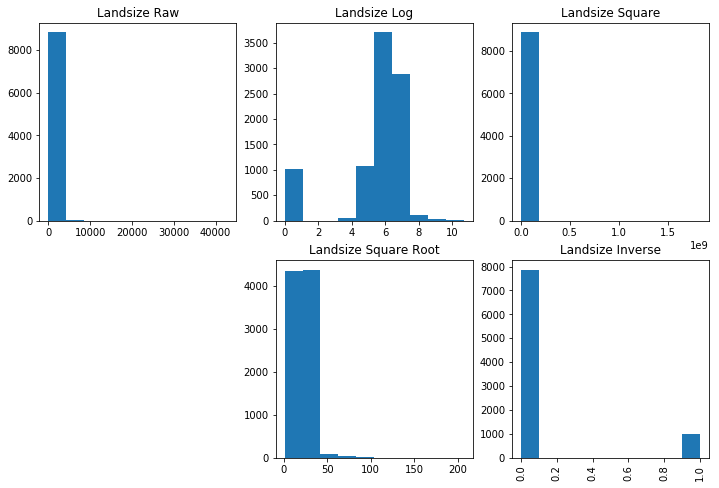

In [28]:
plotcolumn('Landsize')

The log transform of Landsize is ugly, but it's the most normal-looking.

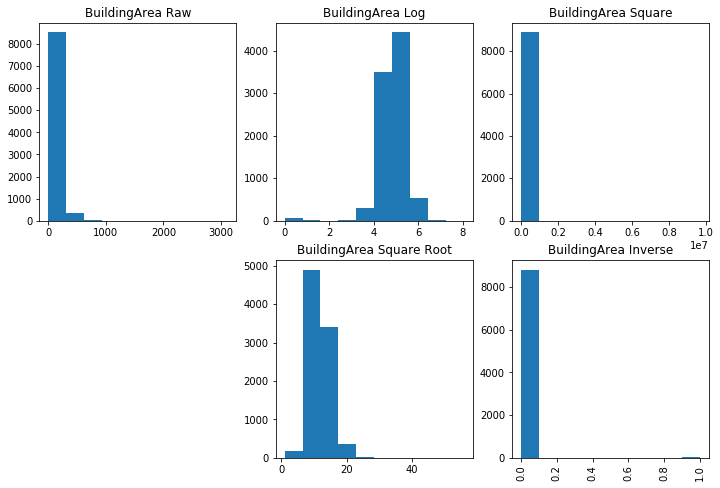

In [29]:
plotcolumn('BuildingArea')

Once again, the log transform looks the most normal for BuildingArea.

# Feature Creation

## Converting 'Type' to several boolean features:

h - house,cottage,villa,semi,terrace

u - unit, duplex

t - townhouse

In [30]:
pd.get_dummies(features['Type']).head()

,h,t,u
2,1,0,0
4,1,0,0
6,1,0,0
11,1,0,0
14,1,0,0


In [31]:
# Townhouse=0 & House=0 means 'Unit'

features['House'] = np.where((features['Type'] == 'h'), 1, 0)
features['Townhouse'] = np.where((features['Type'] == 't'), 1, 0)
features['Unit'] = np.where((features['Type'] == 'u'), 1, 0)

features.drop(['Type'], axis=1, inplace=True)

In [32]:
features['Parking'] = np.where(df['Car'] >= 1, 1, 0)



print(df['Car'].groupby(features['Parking']).describe())

          count      mean       std  min  25%  50%  75%   max
Parking                                                      
0         553.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
1        8334.0  1.804536  0.901123  1.0  1.0  2.0  2.0  10.0


In [33]:
means = df[['Rooms','Bedroom2','Bathroom', 'BuildingArea']].mean(axis=0)
stds = df[['Rooms','Bedroom2','Bathroom', 'BuildingArea']].std(axis=0)
features['Size'] = ((df[['Rooms','Bedroom2','Bathroom', 'BuildingArea']] - means) / stds).mean(axis=1)
features['Size'] = features['Size'] - features['Size'].min()
features['Size'] = features['Size']/features['Size'].max()

In [34]:
features['Size'].max()

1.0

In [35]:
plotdf = df.loc[:, ['Price','Rooms','Bedroom2','Bathroom', 'BuildingArea']]
plotdf['Size'] = features['Size'] 
corrmat2 = plotdf.corr()

print(corrmat2)

                 Price     Rooms  Bedroom2  Bathroom  BuildingArea      Size
Price         1.000000  0.475074  0.460880  0.463501      0.507284  0.551767
Rooms         0.475074  1.000000  0.964465  0.624070      0.606738  0.924639
Bedroom2      0.460880  0.964465  1.000000  0.626493      0.595299  0.922030
Bathroom      0.463501  0.624070  0.626493  1.000000      0.553855  0.811535
BuildingArea  0.507284  0.606738  0.595299  0.553855      1.000000  0.797492
Size          0.551767  0.924639  0.922030  0.811535      0.797492  1.000000


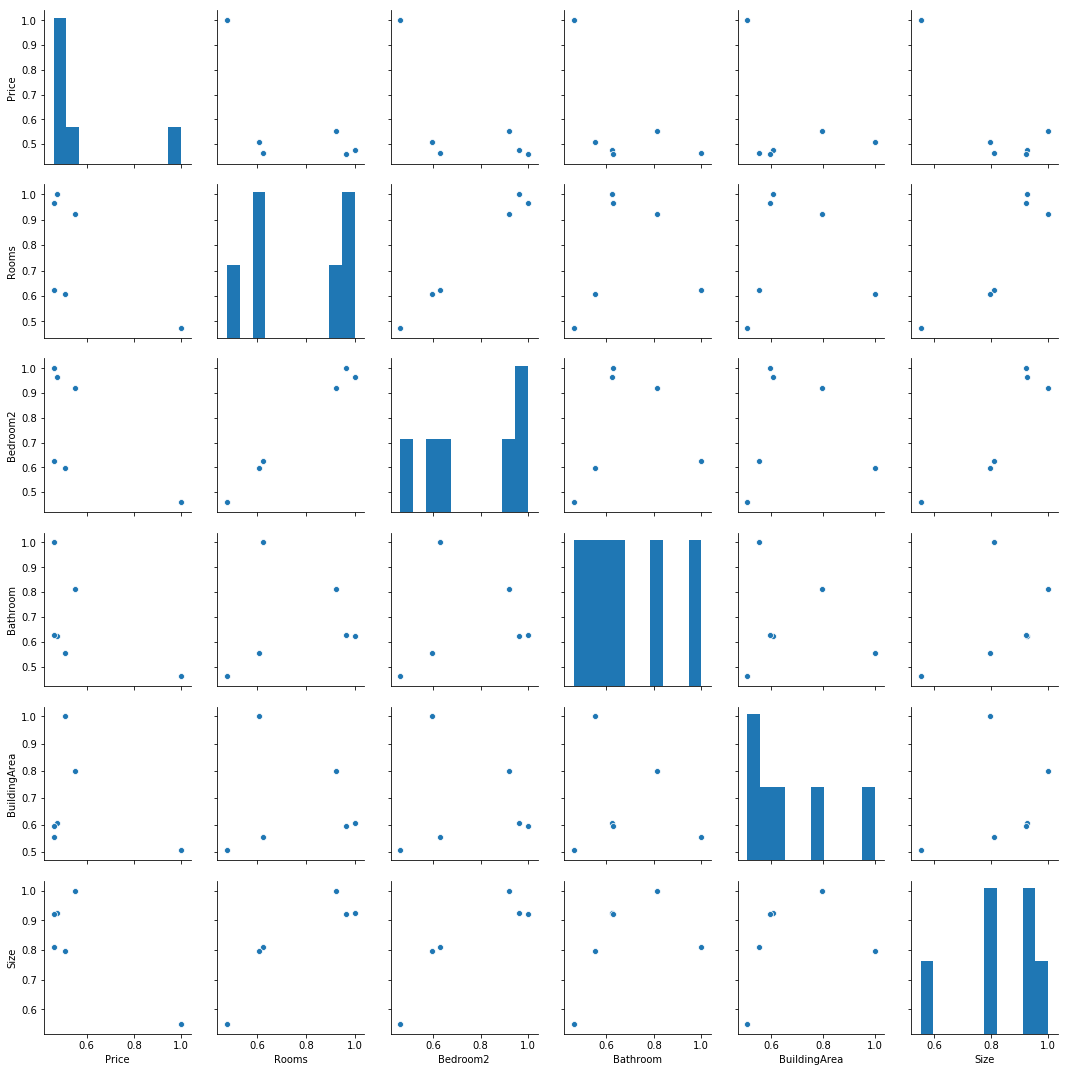

In [36]:
sns.pairplot(corrmat2)

In [37]:
features['Proximity'] = max(features['Distance']) - features['Distance']
features['Proximity'] = features['Proximity']/max(features['Proximity'])

In [38]:
features['LogPrice'] = np.log(features['Price'])

In [39]:
features['LogPropertyCount'] = np.log(features['Propertycount'])

In [40]:
features['LogLandsize'] = np.log(features['Landsize']+1)

In [41]:
features['LogBuildArea'] = np.log(features['BuildingArea']+1)

In [42]:
features['Age'] = features['YearBuilt'].max() - features['YearBuilt']
features['LogAge'] = np.log(features['Age']+1)

In [43]:
features['<20yrs'] = np.where((features['Age'] <= 10), 1, 0)

features['20-40yrs'] = np.where(((features['Age'] > 20) & (features['Age'] <= 40)), 1, 0)

features['40-60yrs'] = np.where(((features['Age'] > 40) & (features['Age'] <= 60)), 1, 0)

features['60-80yrs'] = np.where(((features['Age'] > 60) & (features['Age'] <= 80)), 1, 0)

features['80-100yrs'] = np.where(((features['Age'] > 80) & (features['Age'] <= 100)), 1, 0)

features['100+yrs'] = np.where((features['Age'] > 100), 1, 0)


In [44]:
end = features['Date'].max()

def age_in_months(x):
    return end.month - x.month + 12*(end.year - x.year)

print(end)
print(df_raw.Date.loc[0])
age_in_months(df_raw.Date.loc[0])

2018-10-03 00:00:00
2016-03-09 00:00:00


31

In [45]:
features['SquareProx'] = features['Proximity'].apply(lambda x: x**2)

In [46]:
features['LogDistance'] = np.log(features['Distance']+1)

In [47]:
features['MonthsSinceSale'] = features['Date'].apply(lambda x: age_in_months(x))
features.drop(['Date'], axis=1, inplace=True)

In [48]:
features

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,...,LogAge,<20yrs,20-40yrs,40-60yrs,60-80yrs,80-100yrs,100+yrs,SquareProx,LogDistance,MonthsSinceSale
2,2,1035000.0,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.80790,...,4.779123,0,0,0,0,0,1,0.897297,1.252763,30
4,3,1465000.0,2.5,3.0,2.0,0.0,134.0,150.0,1900.0,-37.80930,...,4.779123,0,0,0,0,0,1,0.897297,1.252763,18
6,4,1600000.0,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,-37.80720,...,1.609438,1,0,0,0,0,0,0.897297,1.252763,30
11,3,1876000.0,2.5,4.0,2.0,0.0,245.0,210.0,1910.0,-37.80240,...,4.691348,0,0,0,0,0,1,0.897297,1.252763,27
14,2,1636000.0,2.5,2.0,1.0,2.0,256.0,107.0,1890.0,-37.80600,...,4.859812,0,0,0,0,0,1,0.897297,1.252763,26
18,2,1097000.0,2.5,3.0,1.0,2.0,220.0,75.0,1900.0,-37.80100,...,4.779123,0,0,0,0,0,1,0.897297,1.252763,26
24,3,1350000.0,2.5,3.0,2.0,2.0,214.0,190.0,2005.0,-37.80850,...,2.639057,0,0,0,0,0,0,0.897297,1.252763,22
25,2,750000.0,2.5,2.0,2.0,1.0,0.0,94.0,2009.0,-37.80780,...,2.302585,1,0,0,0,0,0,0.897297,1.252763,22
30,2,1310000.0,2.5,2.0,1.0,2.0,238.0,97.0,1890.0,-37.80900,...,4.859812,0,0,0,0,0,1,0.897297,1.252763,24
32,3,1200000.0,2.5,3.0,2.0,1.0,113.0,110.0,1880.0,-37.80560,...,4.934474,0,0,0,0,0,1,0.897297,1.252763,27


In [49]:
features.drop(['Distance'], axis=1, inplace=True)
features.drop(['Car'], axis=1, inplace=True)
features.drop(['Rooms', 'Bedroom2', 'Bathroom'], axis=1, inplace=True)
features.drop(['Landsize', 'YearBuilt'], axis=1, inplace=True)
features.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
features.drop(['Age', 'Proximity'], axis=1, inplace=True)
features.drop(['Propertycount'], axis=1, inplace=True)
features.drop(['Price'], axis=1, inplace=True)

## Correlation Matrix for Features

In [50]:
corrmat = features.corr()
corrmat

,BuildingArea,House,Townhouse,Unit,Parking,Size,LogPrice,LogPropertyCount,LogLandsize,LogBuildArea,LogAge,<20yrs,20-40yrs,40-60yrs,60-80yrs,80-100yrs,100+yrs,SquareProx,LogDistance,MonthsSinceSale
BuildingArea,1.000000,0.341111,-0.046365,-0.359105,0.107336,0.797492,0.511586,-0.041188,0.331675,0.755142,-0.107398,0.090394,0.042284,-0.162843,-0.021467,0.073092,-0.021110,-0.155764,0.177228,-0.095141
House,0.341111,1.000000,-0.508906,-0.783523,-0.073524,0.454199,0.439952,-0.067608,0.589939,0.370786,0.316086,-0.206883,0.035711,-0.081182,0.159300,0.124807,0.189779,-0.254896,0.260478,-0.216705
Townhouse,-0.046365,-0.508906,1.000000,-0.136143,0.071485,-0.032683,-0.064272,-0.015916,-0.094815,-0.042014,-0.339886,0.275666,-0.011300,-0.130453,-0.099835,-0.085926,-0.100882,0.038961,-0.024096,0.049805
Unit,-0.359105,-0.783523,-0.136143,1.000000,0.033017,-0.499130,-0.459931,0.089296,-0.610499,-0.396397,-0.118435,0.039111,-0.032942,0.187593,-0.111270,-0.081612,-0.145591,0.265228,-0.282382,0.213448
Parking,0.107336,-0.073524,0.071485,0.033017,1.000000,0.141198,-0.021115,-0.000056,0.044432,0.089096,-0.211451,0.089746,0.053792,0.076328,0.036721,-0.044039,-0.329048,-0.183643,0.216508,-0.013742
Size,0.797492,0.454199,-0.032683,-0.499130,0.141198,1.000000,0.585499,-0.064578,0.447001,0.671882,-0.123180,0.101986,0.081602,-0.177335,-0.012769,0.060621,-0.038517,-0.263727,0.283097,-0.193773
LogPrice,0.511586,0.439952,-0.064272,-0.459931,-0.021115,0.585499,1.000000,-0.029690,0.360029,0.467280,0.247654,-0.085342,-0.102944,-0.245797,0.092960,0.237717,0.299997,0.231272,-0.198895,-0.025704
LogPropertyCount,-0.041188,-0.067608,-0.015916,0.089296,-0.000056,-0.064578,-0.029690,1.000000,-0.089515,-0.054068,-0.005521,0.010027,0.015656,-0.023699,-0.055403,0.041485,0.016562,0.050127,-0.068771,-0.011784
LogLandsize,0.331675,0.589939,-0.094815,-0.610499,0.044432,0.447001,0.360029,-0.089515,1.000000,0.351238,0.103770,-0.065340,0.070687,-0.069781,0.116854,0.065727,0.010293,-0.357469,0.383323,-0.252598
LogBuildArea,0.755142,0.370786,-0.042014,-0.396397,0.089096,0.671882,0.467280,-0.054068,0.351238,1.000000,-0.054769,0.046184,0.052998,-0.164150,0.011631,0.074643,0.004429,-0.172631,0.190185,-0.095850


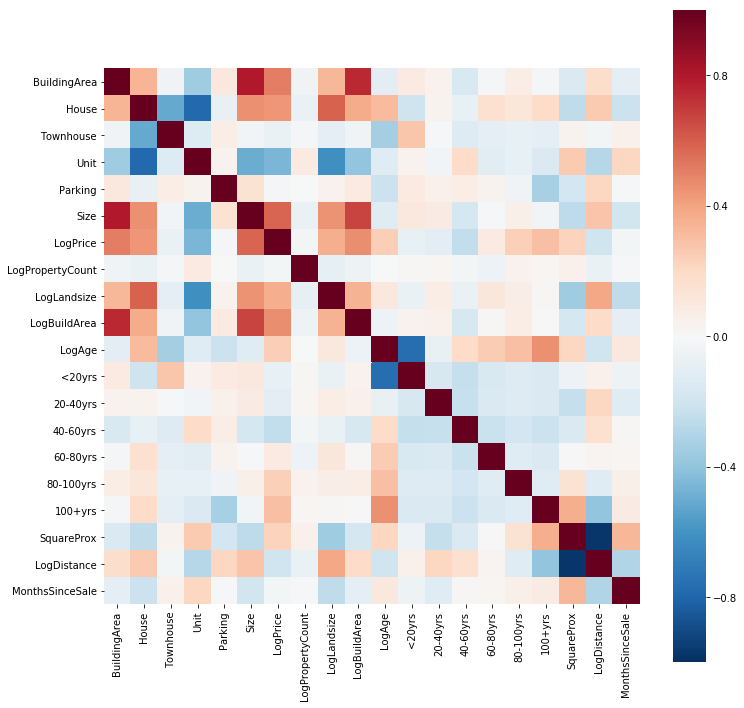

In [51]:
plt.rcParams['figure.figsize'] = 12, 12

f = sns.heatmap(corrmat, vmin= -1, vmax=1, square=True, cmap="RdBu_r")

plt.show()

In [52]:
"""sns.pairplot(features)

plt.show()"""

'sns.pairplot(features)\n\nplt.show()'

### Comparison of Price of Houses and Other Property Types

In [53]:
print("Houses:\n", features[features['House'] == 1]['LogPrice'].describe(), "\n\nOther Properties:\n",
      features[features['House'] == 0]['LogPrice'].describe())

Houses:
 count    6625.000000
mean       13.891464
std         0.499153
min        11.782953
25%        13.521810
50%        13.859527
75%        14.220976
max        16.012735
Name: LogPrice, dtype: float64 

Other Properties:
 count    2262.000000
mean       13.351335
std         0.420226
min        12.043554
25%        13.060488
50%        13.329378
75%        13.617060
max        15.155761
Name: LogPrice, dtype: float64


In [54]:
stats.ttest_ind(features[features['House'] == 1]['LogPrice'],
      features[features['House'] == 0]['LogPrice'], equal_var=False)

Ttest_indResult(statistic=50.219860758530814, pvalue=0.0)

### Normalization using Preprocessing

In [55]:
names = features.columns
features_scaled = pd.DataFrame(preprocessing.scale(features), columns=names)

In [56]:
print(features_scaled.describe())

       BuildingArea         House     Townhouse          Unit       Parking  \
count  8.887000e+03  8.887000e+03  8.887000e+03  8.887000e+03  8.887000e+03   
mean  -3.353031e-17 -2.347699e-14 -2.901021e-15  9.726763e-15 -1.693805e-15   
std    1.000056e+00  1.000056e+00  1.000056e+00  1.000056e+00  1.000056e+00   
min   -1.698230e+00 -1.711381e+00 -2.973654e-01 -4.578312e-01 -3.882077e+00   
25%   -5.608408e-01 -1.711381e+00 -2.973654e-01 -4.578312e-01  2.575940e-01   
50%   -1.968762e-01  5.843235e-01 -2.973654e-01 -4.578312e-01  2.575940e-01   
75%    3.490708e-01  5.843235e-01 -2.973654e-01 -4.578312e-01  2.575940e-01   
max    3.369733e+01  5.843235e-01  3.362865e+00  2.184211e+00  2.575940e-01   

               Size      LogPrice  LogPropertyCount   LogLandsize  \
count  8.887000e+03  8.887000e+03      8.887000e+03  8.887000e+03   
mean  -5.778607e-16  3.463841e-15     -5.775952e-16  2.167925e-15   
std    1.000056e+00  1.000056e+00      1.000056e+00  1.000056e+00   
min   -2.000

## PCA

In [57]:
features_pca = features[['LogPrice', 'LogBuildArea', 'LogLandsize', 'LogAge', 'LogDistance']]

In [58]:
"""sns.pairplot(features_pca)

plt.show()"""

'sns.pairplot(features_pca)\n\nplt.show()'

In [59]:
features['BuildingArea'].value_counts()

120.0000     134
110.0000     110
130.0000     104
100.0000     103
115.0000     101
150.0000      98
140.0000      93
160.0000      81
104.0000      80
112.0000      79
125.0000      77
135.0000      73
90.0000       72
180.0000      70
105.0000      69
138.0000      69
107.0000      68
102.0000      67
108.0000      67
118.0000      67
145.0000      66
106.0000      66
95.0000       65
109.0000      65
132.0000      64
170.0000      63
85.0000       63
80.0000       63
70.0000       62
133.0000      62
            ... 
109.5000       1
416.0000       1
697.0000       1
180.5600       1
463.0000       1
1041.0000      1
349.0000       1
450.0000       1
406.0000       1
93.8400        1
375.0000       1
115.9600       1
345.0000       1
148.4700       1
121.8000       1
430.0000       1
106.4000       1
157.9352       1
266.7600       1
534.0000       1
454.0000       1
266.5300       1
105.2300       1
653.0000       1
654.0000       1
156.6000       1
409.5400       1
408.0000      

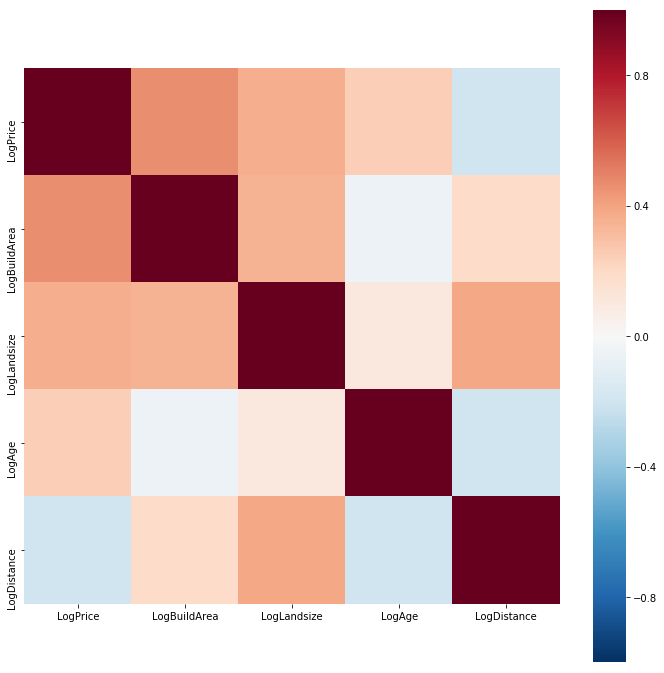

In [60]:
plt.rcParams['figure.figsize'] = 12, 12

f = sns.heatmap(features_pca.corr(), vmin= -1, vmax=1, square=True, cmap="RdBu_r")

plt.show()

In [61]:
X = StandardScaler().fit_transform(features_pca)

Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00011254  0.46733259  0.36006923  0.24768182 -0.19891766]
 [ 0.46733259  1.00011254  0.35127767 -0.0547756   0.19020676]
 [ 0.36006923  0.35127767  1.00011254  0.10378149  0.38336588]
 [ 0.24768182 -0.0547756   0.10378149  1.00011254 -0.20175877]
 [-0.19891766  0.19020676  0.38336588 -0.20175877  1.00011254]]


In [62]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, len(features_pca.columns)).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[ 0.53368744]
 [ 0.56543356]
 [ 0.571638  ]
 [ 0.13397735]
 [ 0.22526137]]
Eigenvalue 1: 1.8591360813640239
----------------------------------------
Eigenvector 2: 
[[ 0.42456249]
 [-0.06933464]
 [-0.18753934]
 [ 0.55558585]
 [-0.68636198]]
Eigenvalue 2: 1.410437413038506
----------------------------------------
Eigenvector 3: 
[[ 0.2436175 ]
 [ 0.44695628]
 [-0.3673134 ]
 [-0.69282187]
 [-0.35490749]]
Eigenvalue 3: 0.9000251949443177
----------------------------------------
Eigenvector 4: 
[[ 0.64087402]
 [-0.36139601]
 [-0.43485084]
 [-0.04233581]
 [ 0.51748028]]
Eigenvalue 4: 0.31528166105885336
----------------------------------------
Eigenvector 5: 
[[-0.25466727]
 [ 0.58745265]
 [-0.56039684]
 [ 0.4376985 ]
 [ 0.29055013]]
Eigenvalue 5: 0.5156823324662324
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [ 0.37178538  0.28205574  0.17998478  0.06304924  0.10312486]


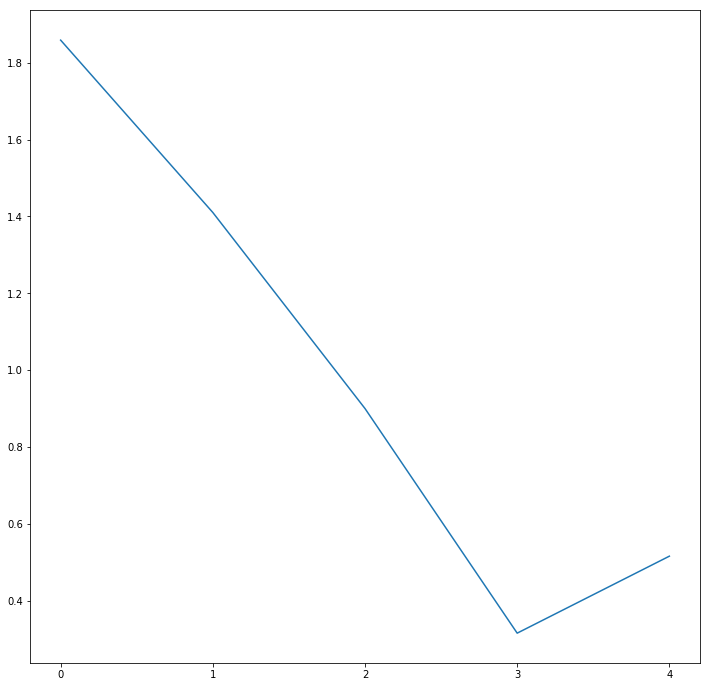

In [63]:
plt.plot(eig_val_cov)

plt.xticks(np.arange(0,(len(features_pca.columns))))
plt.show()

The first major change in slope on this scree plot shows that about 3 components are sufficient for a model of this dataset.

In [64]:
features_pca.columns

Index(['LogPrice', 'LogBuildArea', 'LogLandsize', 'LogAge', 'LogDistance'], dtype='object')

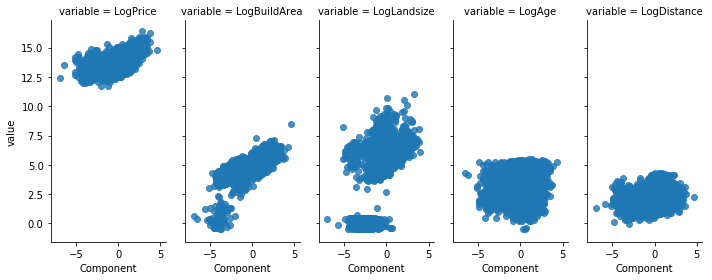

In [65]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes.
data_to_plot = features_pca[features_pca.columns]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", height=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.37178538  0.28205574  0.17998478  0.10312486  0.06304924]


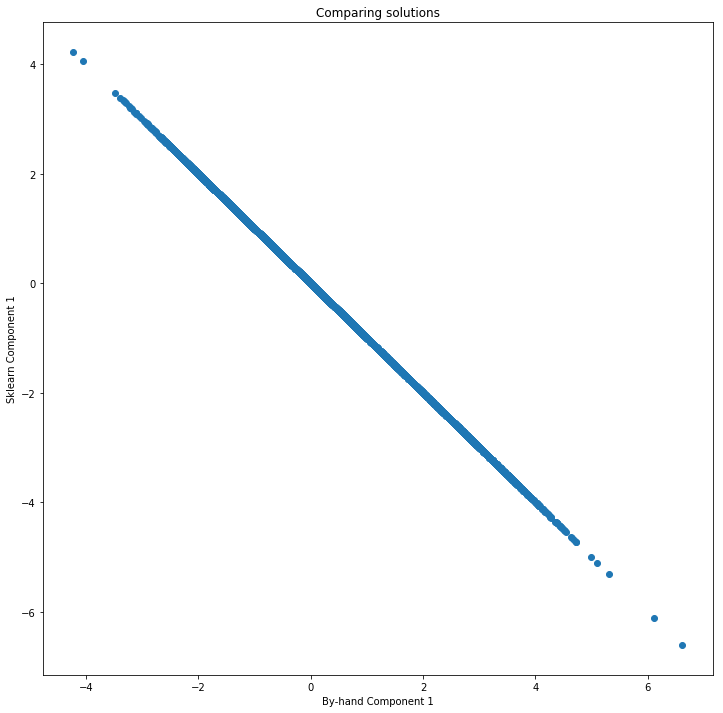

In [66]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

# Feature Subset

In [67]:
corrmagnitude = pd.DataFrame(corrmat['LogPrice']).reset_index().rename(columns={'index': 'Column',
                                                                'LogPrice': 'PriceCorrMagnitude'})
corrmagnitude['PriceCorrMagnitude'] = corrmagnitude['PriceCorrMagnitude'].apply(lambda x: abs(x))

corrmagnitude.sort_values(by='PriceCorrMagnitude', ascending=False)

,Column,PriceCorrMagnitude
6,LogPrice,1.000000
5,Size,0.585499
0,BuildingArea,0.511586
9,LogBuildArea,0.467280
3,Unit,0.459931
1,House,0.439952
8,LogLandsize,0.360029
16,100+yrs,0.299997
10,LogAge,0.247654
13,40-60yrs,0.245797


We are ignorning the categorical Boolean variables here because they are strongly correlated with "Size" in the case of House/Unit and with "LogAge" in the case of the property age brackets. LogLandsize could also be discarded for the same reason (it is correlated with "Size").

In [68]:
reduced_features = features.loc[:, ['LogPrice', 'Size', 'LogLandsize', 'LogAge', 'SquareProx']]

In [69]:
corrmat = reduced_features.corr()
corrmat

,LogPrice,Size,LogLandsize,LogAge,SquareProx
LogPrice,1.000000,0.585499,0.360029,0.247654,0.231272
Size,0.585499,1.000000,0.447001,-0.123180,-0.263727
LogLandsize,0.360029,0.447001,1.000000,0.103770,-0.357469
LogAge,0.247654,-0.123180,0.103770,1.000000,0.216396
SquareProx,0.231272,-0.263727,-0.357469,0.216396,1.000000


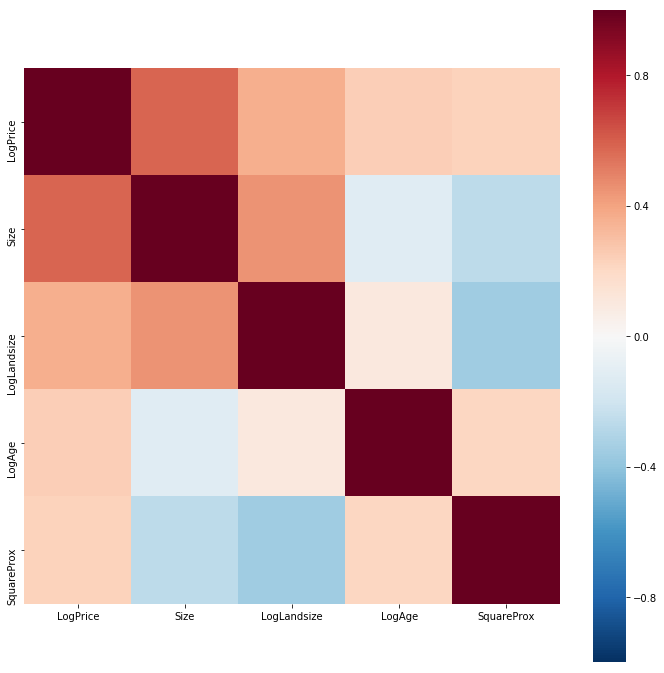

In [70]:
plt.rcParams['figure.figsize'] = 12, 12

f = sns.heatmap(corrmat, vmin= -1, vmax=1, square=True, cmap="RdBu_r")

plt.show()

# Linear Regression

In [165]:
reg = LinearRegression()

def lr_model_results(X, y):

    #Instantiate Linear Regression model:
    reg = LinearRegression()

    # Fit our model to our data.
    reg.fit(X, y)

    # Inspect the result:
    print('\nCoefficients: \n', reg.coef_)
    print('\nIntercept: \n', reg.intercept_)
    print('\nR-squared:')
    print(reg.score(X, y), '\n')

    cvscore = cross_val_score(reg, X, y, cv=10)
    print('Cross-Validation Score:\n', cvscore)
    print('Cross-Validation Mean:\n', cvscore.mean())
    print('Cross-Validation +/- (2x STD):\n', (cvscore.std()*2))

## Feature Set 1

In [166]:
reduced_features2 = pd.DataFrame(reduced_features)

In [167]:
reduced_features2.LogPrice.describe()

count    8887.000000
mean       13.753986
std         0.534812
min        11.782953
25%        13.370785
50%        13.710150
75%        14.111905
max        16.012735
Name: LogPrice, dtype: float64

### Model Coefficients and Cross-Validation

In [168]:
linear_formula = 'LogPrice ~ Size+LogLandsize+LogAge+SquareProx'
data = reduced_features2

lm = smf.ols(formula=linear_formula, data=data).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept      11.629910
Size            4.398568
LogLandsize     0.054504
LogAge          0.119531
SquareProx      1.192439
dtype: float64

Intercept       0.000000e+00
Size            0.000000e+00
LogLandsize    6.023855e-141
LogAge         2.371735e-183
SquareProx      0.000000e+00
dtype: float64

0.59539075867907321

,0,1
Intercept,11.586824,11.672996
Size,4.293196,4.503939
LogLandsize,0.050353,0.058655
LogAge,0.111606,0.127455
SquareProx,1.151140,1.233737


In [169]:
X = reduced_features2[['Size', 'LogLandsize', 'LogAge', 'SquareProx']]
y = reduced_features2.LogPrice.values.reshape(-1, 1)

In [170]:
lr_model_results(X, y)


Coefficients: 
 [[ 4.39856758  0.05450419  0.11953058  1.19243869]]

Intercept: 
 [ 11.62990973]

R-squared:
0.595390758679 

Cross-Validation Score:
 [ 0.53567114  0.64866386  0.63879326  0.62011633  0.5770268   0.56006061
  0.52044972  0.53052871  0.53079082  0.59128233]
Cross-Validation Mean:
 0.575338358939
Cross-Validation +/- (2x STD):
 0.0905037667251


### Visualization of Residuals:

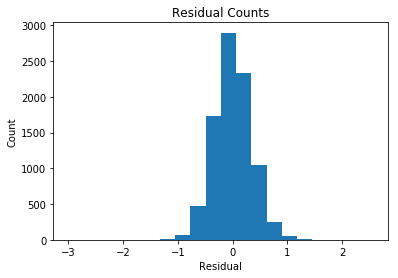

In [171]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = reduced_features2['LogPrice']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual, bins=20)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

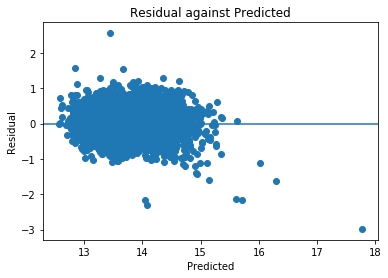

In [172]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

## Feature Set 2 (Reduced):

In [173]:
reduced_features3 = pd.DataFrame(reduced_features)
reduced_features3['SizeSquareProx'] = reduced_features3['Size']*reduced_features3['SquareProx']

### Model Coefficients and Cross-Validation

In [174]:
linear_formula = 'LogPrice ~ SizeSquareProx'
data = reduced_features3

lm = smf.ols(formula=linear_formula, data=data).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept         13.077215
SizeSquareProx     7.624435
dtype: float64

Intercept         0.0
SizeSquareProx    0.0
dtype: float64

0.5329261966127059

,0,1
Intercept,13.062004,13.092426
SizeSquareProx,7.475997,7.772873


In [175]:
X = reduced_features3[['SizeSquareProx']]
y = reduced_features3.LogPrice.values.reshape(-1, 1)

In [176]:
lr_model_results(X, y)


Coefficients: 
 [[ 7.62443495]]

Intercept: 
 [ 13.07721495]

R-squared:
0.532926196613 

Cross-Validation Score:
 [ 0.44226206  0.57220644  0.53140474  0.55495709  0.50848184  0.54594335
  0.48882574  0.45807569  0.48996748  0.53984848]
Cross-Validation Mean:
 0.513197292077
Cross-Validation +/- (2x STD):
 0.0814029269355


### Visualization of Residuals:

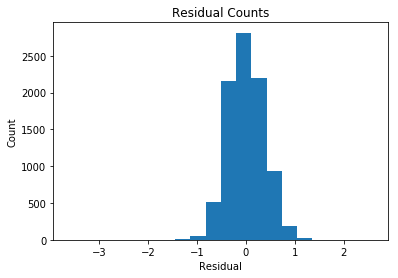

In [160]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = reduced_features3['LogPrice']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual, bins=20)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

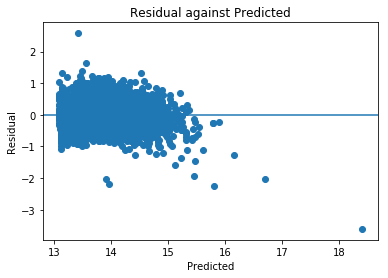

In [161]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

# KNN Regression

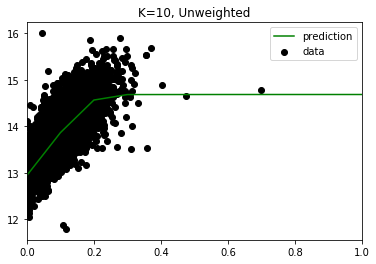

In [162]:
knn = neighbors.KNeighborsRegressor(n_neighbors=335)
X = reduced_features3[['SizeSquareProx']]
Y = reduced_features3.LogPrice.values.reshape(-1, 1)
knn.fit(X, Y)

T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.xlim(0, 1)
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

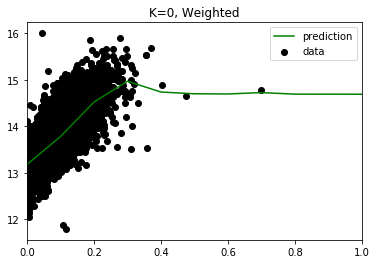

In [163]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=335, weights='distance')
X = reduced_features3[['SizeSquareProx']]
Y = reduced_features3.LogPrice.values.reshape(-1, 1)

knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.xlim(0, 1)
plt.legend()
plt.title('K=0, Weighted')
plt.show()

In [164]:
score = cross_val_score(knn, X, Y, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.53 (+/- 0.09)
Weighted Accuracy: 0.47 (+/- 0.08)


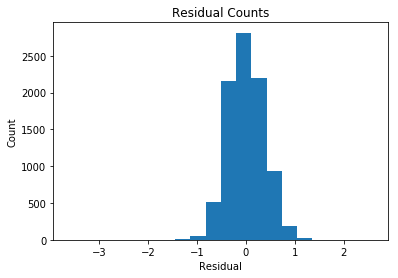

In [147]:
knn.fit(X, Y)
predicted = reg.predict(X).ravel()
actual = reduced_features3['LogPrice']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual, bins=20)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

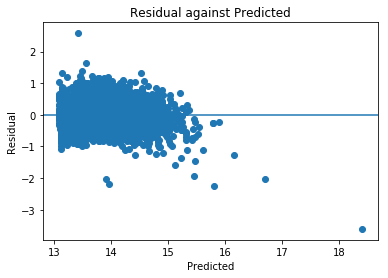

In [133]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

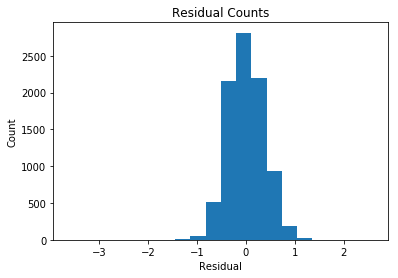

In [134]:
knn_w.fit(X, Y)
predicted = reg.predict(X).ravel()
actual = reduced_features3['LogPrice']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual, bins=20)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Conclusions:

For this particular model, the accuracy for linear regression and unweighted KNN regression on on the same features (LogPrice dependent on the product of LogSize and SquareProximity) are roughly the same, with cross-validation showing a mean R-squared value of about 0.53 and 2 standard deviations being about 0.09. The weighted KNN regression model shows a mean R-squared value of 0.49 with 2 standard deviations = 0.08. However, better accuracy is achieved using a multivariate linear regression model of LogPrice as the target variable for a regression on LogSize, LogLandsize, LogAge, and SquareProximity. This model has an R-squared value of 0.57, with roughly the same standard deviation.

Unweighted KNN regression was comparable to a simple linear regression, but didn't allow for modeling more than one feature. Weighted regression was slightly less accurate.